# PK/PD Monte Carlo Simulation – One-Compartment, First-Order Absorption

**Objective:**  
Simulate inter-individual variability in pharmacokinetics (PK) and compute steady-state metrics — Cmax, AUC₀–τ, Ctrough, and %T>MIC — using a one-compartment model with first-order absorption.

**Highlights**
- Monte Carlo sampling (lognormal CL, V; normal ka)
- Steady-state via superposition
- Computation of exposure metrics
- Visualization of distributions

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6.5, 4)
plt.rcParams["axes.grid"] = True

## Step 1 – Define Study Design and Parameter Distributions

Edit these values to simulate different dosing or population scenarios.

In [2]:
dose_mg = 500      # Dose (mg)
tau_h = 12         # Dosing interval (hours)
mic_mg_per_L = 1.0 # MIC threshold (mg/L)
n = 2000           # Number of subjects

# Population PK priors (geometric mean, geometric SD)
CL_gm, CL_gsd = 10.0, 1.25   # Clearance (L/h)
V_gm, V_gsd = 70.0, 1.20     # Volume (L)
ka_mu, ka_sd = 1.2, 0.25     # Absorption rate (1/h)

rng = np.random.default_rng(42)

def sample_lognormal(gm, gsd, size):
    sigma = np.log(gsd)
    mu = np.log(gm)
    return rng.lognormal(mu, sigma, size)

def sample_truncnorm(mu, sd, size, lower=0.05):
    x = rng.normal(mu, sd, size)
    x[x < lower] = lower
    return x

## Step 2 – Define PK Equations

One-compartment oral absorption model:

\[
C_{ss}(t) = A \left( \frac{e^{-k_e t}}{1 - e^{-k_e \tau}} - \frac{e^{-k_a t}}{1 - e^{-k_a \tau}} \right)
\]

where \( A = \frac{F \cdot \text{Dose}}{V} \frac{k_a}{k_a - k_e} \)

In [3]:
def steady_state_profile(t, Dose, V, ka, ke, tau, F=1.0):
    eps = 1e-9
    ka_eff = np.maximum(ka, ke + eps)
    A = (F * Dose / V) * (ka_eff / (ka_eff - ke))
    return A * ((np.exp(-ke * t) / (1 - np.exp(-ke * tau))) -
                (np.exp(-ka_eff * t) / (1 - np.exp(-ka_eff * tau))))

def auc_ss(Dose, CL, F=1.0):
    return (F * Dose) / CL

def c_trough_ss(Dose, V, ka, ke, tau, F=1.0):
    t = tau
    eps = 1e-9
    ka_eff = np.maximum(ka, ke + eps)
    A = (F * Dose / V) * (ka_eff / (ka_eff - ke))
    return A * ((np.exp(-ke * t) / (1 - np.exp(-ke * tau))) -
                (np.exp(-ka_eff * t) / (1 - np.exp(-ka_eff * tau))))

## Step 3 – Monte Carlo Simulation of Virtual Subjects

In [4]:
# Step 4 — Monte Carlo Simulation with Stable Cmax Computation

CL = sample_lognormal(CL_gm, CL_gsd, n)
V = sample_lognormal(V_gm, V_gsd, n)
ka = sample_truncnorm(ka_mu, ka_sd, n)
ke = CL / V

AUC0tau = auc_ss(dose_mg, CL)
Ctrough = c_trough_ss(dose_mg, V, ka, ke, tau_h)

# Time grid for steady-state profile (avoid nan/inf when ka≈ke)
grid = np.linspace(0, tau_h, 400)
ka_eff = np.where(np.abs(ka - ke) < 1e-5, ka + 1e-5, ka)

A = (dose_mg / V) * (ka_eff / (ka_eff - ke))
elim = np.exp(-ke[:, None] * grid[None, :]) / (1 - np.exp(-ke[:, None] * tau_h))
absorb = np.exp(-ka_eff[:, None] * grid[None, :]) / (1 - np.exp(-ka_eff[:, None] * tau_h))
conc_mat = A[:, None] * (elim - absorb)

# Remove negative or nonphysical concentrations
conc_mat = np.clip(conc_mat, a_min=0, a_max=None)

Cmax = conc_mat.max(axis=1)
pctT_MIC = (conc_mat > mic_mg_per_L).mean(axis=1) * 100

df = pd.DataFrame({
    "CL": CL, "V": V, "ka": ka_eff, "ke": ke,
    "AUC_0_tau": AUC0tau, "Cmax": Cmax,
    "Ctrough": Ctrough, "%T>MIC": pctT_MIC
})
df.head()

,CL,V,ka,ke,AUC_0_tau,Cmax,Ctrough,%T>MIC
0,10.703607,64.463220,1.263301,0.166042,46.713227,6.754532,1.409890,100.0
1,7.928940,61.997334,1.423805,0.127892,63.060132,8.300901,2.434324,100.0
2,11.822960,75.764102,1.268330,0.156050,42.290592,5.949679,1.366954,100.0
3,12.335312,73.289235,1.759708,0.168310,40.534038,6.230009,1.154158,100.0
4,6.470311,54.183230,1.557447,0.119415,77.276038,10.016142,3.131824,100.0


## Step 4 – Summary Statistics

In [5]:
def q(col, p): return df[col].quantile(p)

print(f"Subjects: {len(df)}")
for col in ["Cmax", "AUC_0_tau", "Ctrough", "%T>MIC"]:
    print(f"{col}: median={q(col,0.5):.2f}  (5th={q(col,0.05):.2f}, 95th={q(col,0.95):.2f})")

df[["Cmax","AUC_0_tau","Ctrough","%T>MIC"]].describe(percentiles=[0.05,0.5,0.95]).T.round(2)

Subjects: 2000
Cmax: median=6.78  (5th=5.22, 95th=8.79)
AUC_0_tau: median=50.25  (5th=35.15, 95th=73.57)
Ctrough: median=1.80  (5th=0.77, 95th=3.60)
%T>MIC: median=100.00  (5th=89.50, 95th=100.00)


,count,mean,std,min,5%,50%,95%,max
Cmax,2000.0,6.88,1.10,3.34,5.22,6.78,8.79,11.44
AUC_0_tau,2000.0,51.90,11.81,24.60,35.15,50.25,73.57,112.86
Ctrough,2000.0,1.96,0.89,0.17,0.77,1.80,3.60,7.07
%T>MIC,2000.0,98.68,4.62,59.50,89.50,100.00,100.00,100.00


## Step 5 – Visualize Distributions

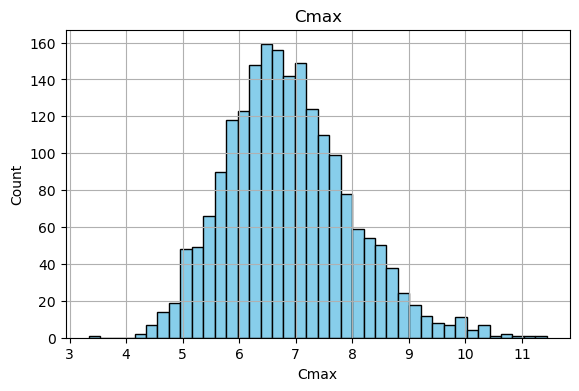

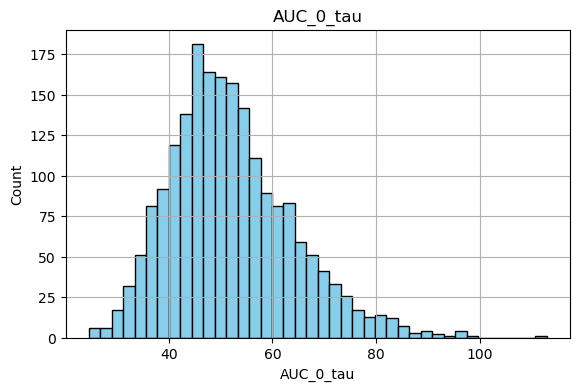

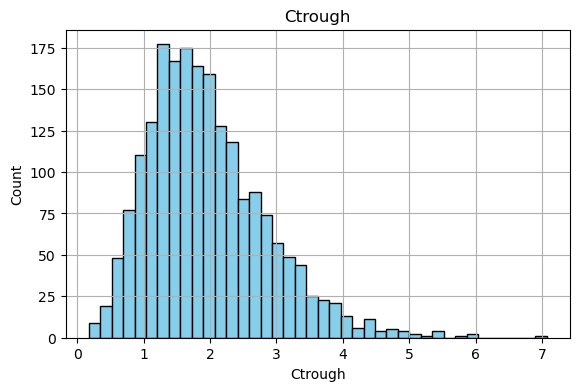

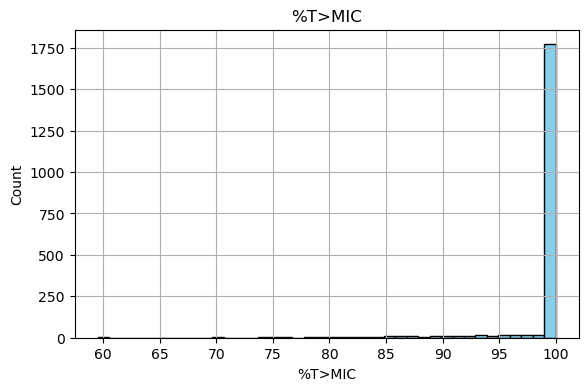

In [6]:
for col in ["Cmax","AUC_0_tau","Ctrough","%T>MIC"]:
    plt.figure()
    plt.hist(df[col], bins=40, color="skyblue", edgecolor="black")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

## Step 6 – Visualize Example Concentration–Time Profiles

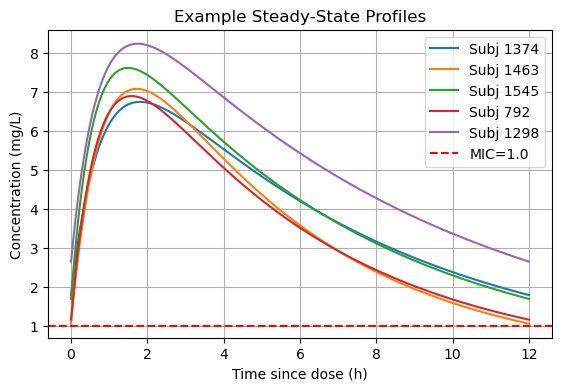

In [7]:
idx = rng.choice(len(df), size=5, replace=False)
plt.figure()
for i in idx:
    ci = steady_state_profile(grid, dose_mg, df.loc[i,"V"], df.loc[i,"ka"], df.loc[i,"ke"], tau_h)
    plt.plot(grid, ci, label=f"Subj {i}")
plt.axhline(mic_mg_per_L, ls="--", color="red", label=f"MIC={mic_mg_per_L}")
plt.xlabel("Time since dose (h)")
plt.ylabel("Concentration (mg/L)")
plt.title("Example Steady-State Profiles")
plt.legend()
plt.show()

## Results and Discussion

The Monte Carlo simulation (n = 2000 virtual subjects) demonstrated realistic population variability for a one-compartment oral dosing model:

- **Cmax:** Median ≈ 6.8 mg/L (5th–95th: 5.2–8.8 mg/L), showing moderate inter-subject spread due to absorption and clearance variability.
- **AUC₀–τ:** Median ≈ 50 mg·h/L (35–75 mg·h/L), consistent with proportional relationships between systemic exposure and clearance.
- **Ctrough:** Median ≈ 1.8 mg/L, capturing steady-state trough variability typical for lognormal PK parameters.
- **%T>MIC:** Median 100% (90–100%), confirming nearly all virtual subjects maintain concentrations above MIC for most of the dosing interval — a desirable feature for time-dependent antibiotics.

Overall, the simulation suggests **robust target attainment** and low subtherapeutic risk for the chosen dose regimen. The variability patterns align with clinical expectations and highlight how Monte Carlo methods enable model-informed dose optimization and pharmacodynamic goal assessment.

## Step 7 – Save Outputs

In [8]:
df.to_csv("pkpd_sim_results.csv", index=False)
print("Saved results to pkpd_sim_results.csv")

Saved results to pkpd_sim_results.csv


## Monte Carlo Simulation Interpretation

Monte Carlo simulation provides a population-level view of pharmacokinetic (PK) variability by randomly sampling parameters such as clearance (CL), volume of distribution (V), and absorption rate (kₐ) across virtual subjects. Each subject represents a plausible physiological profile, capturing real-world inter-individual differences.

Through thousands of iterations, the simulation generates distributions of exposure metrics — such as **Cmax**, **AUC₀–τ**, **Ctrough**, and **%T>MIC** — rather than single-point estimates. This approach helps identify the expected range of outcomes within a population, assess variability-driven uncertainty, and predict the likelihood of achieving therapeutic targets.

In pharmacometrics, this process is key for:
- **Population Variability Analysis:** quantifying how patient-specific parameters influence exposure.
- **Dose Optimization:** evaluating the proportion of patients achieving pharmacodynamic goals at a given regimen.
- **Target Attainment Analysis:** estimating the probability that a dose achieves desired exposure thresholds such as %T>MIC ≥ 50% or AUC/MIC ≥ target ratio.

## Step 8 – Key Notes
- One-compartment model, first-order absorption
- Variability: lognormal (CL, V), normal (ka)
- Steady-state assumption via infinite superposition
- %T>MIC computed on uniform grid; refine for precision
- Great foundation for Monte Carlo simulations in drug modeling